In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import h5py
import requests
import os

In [33]:
import warnings
warnings.filterwarnings("ignore")

## Read Data with Pandas

In [34]:
df = pd.read_csv("prices-split-adjusted.csv", index_col = 0)
df["adj close"] = df.close # Moving close to the last column
df.drop(['close'], 1, inplace=True) # Moving close to the last column
df.head()

,symbol,open,low,high,volume,adj close
date,,,,,,
2016-01-05,WLTW,123.430000,122.309998,126.250000,2163600.0,125.839996
2016-01-06,WLTW,125.239998,119.940002,125.540001,2386400.0,119.980003
2016-01-07,WLTW,116.379997,114.930000,119.739998,2489500.0,114.949997
2016-01-08,WLTW,115.480003,113.500000,117.440002,2006300.0,116.620003
2016-01-11,WLTW,117.010002,114.089996,117.330002,1408600.0,114.970001


In [35]:
df2 = pd.read_csv("fundamentals.csv")
df2.head()

,Unnamed: 0,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,...,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,0,AAL,2012-12-31,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,...,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-367000000.0,2012.0,-5.60,3.350000e+08
1,1,AAL,2013-12-31,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,...,1.432300e+10,1.380600e+10,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.0,2013.0,-11.25,1.630222e+08
2,2,AAL,2014-12-31,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,...,1.175000e+10,1.340400e+10,2.021000e+09,4.120400e+10,4.322500e+10,4.265000e+10,0.0,2014.0,4.02,7.169154e+08
3,3,AAL,2015-12-31,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,...,9.985000e+09,1.360500e+10,5.635000e+09,4.278000e+10,4.841500e+10,4.099000e+10,0.0,2015.0,11.39,6.681299e+08
4,4,AAP,2012-12-29,2.409453e+09,-89482000.0,6.000000e+05,32.0,-2.711820e+08,5.202150e+08,23.0,...,3.184200e+09,2.559638e+09,1.210694e+09,3.403120e+09,4.613814e+09,6.205003e+09,-27095000.0,2012.0,5.29,7.328355e+07


## Extract all symbols from the list

In [36]:
symbols = list(set(df.symbol))
len(symbols)

501

In [37]:
symbols[:15] # Example of what is in symbols

['BLL',
 'SWN',
 'DD',
 'PEP',
 'A',
 'AZO',
 'CSX',
 'BSX',
 'CCL',
 'UNH',
 'UAA',
 'APC',
 'DOV',
 'MAC',
 'MCK']

## Extract a particular price for stock in symbols

In [38]:
df = df[df.symbol == 'GOOG']
df.drop(['symbol'],1,inplace=True)
df.head()

,open,low,high,volume,adj close
date,,,,,
2010-01-04,312.304948,310.955001,313.580158,3927000.0,312.205308
2010-01-05,312.419511,309.610028,312.748278,6031900.0,310.830459
2010-01-06,311.761979,302.048370,311.761979,7987100.0,302.994813
2010-01-07,303.562685,295.218951,303.861575,12876600.0,295.941242
2010-01-08,294.895159,293.455551,300.499172,9483900.0,299.886470


## Normalize the data

In [39]:
def normalize_data(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
    df['adj close'] = min_max_scaler.fit_transform(df['adj close'].values.reshape(-1,1))
    return df
df = normalize_data(df)
df.head()

,open,low,high,volume,adj close
date,,,,,
2010-01-04,0.157047,0.161167,0.156390,0.131722,0.159399
2010-01-05,0.157238,0.158884,0.154995,0.202469,0.157092
2010-01-06,0.156140,0.146049,0.153341,0.268184,0.143942
2010-01-07,0.142436,0.134457,0.140094,0.432522,0.132105
2010-01-08,0.127950,0.131464,0.134455,0.318492,0.138726


## Training set and Testing set

In [40]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns) # 5
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    train = result[:int(row), :] # 90% date, all features 
    
    x_train = train[:, :-1] 
    y_train = train[:, -1][:,-1]
    
    x_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [41]:
def build_model(layers):
    d = 0.3
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    # adam = keras.optimizers.Adam(decay=0.2)
        
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

## Train Model

In [42]:
window = 60
X_train, y_train, X_test, y_test = load_data(df, window)
print (X_train[0], y_train[0])

[[0.15704696 0.16116746 0.15638998 0.1317225  0.15939908]
 [0.15723843 0.15888449 0.15499506 0.20246902 0.15709185]
 [0.15613951 0.14604929 0.15334121 0.26818406 0.14394234]
 [0.14243617 0.13445699 0.14009362 0.43252209 0.13210528]
 [0.12795029 0.13146379 0.13445546 0.3184921  0.13872603]
 [0.13832355 0.1356323  0.13546617 0.48640628 0.1379653 ]
 [0.13265404 0.13052526 0.13020388 0.3271972  0.12907917]
 [0.11503787 0.1186032  0.12203482 0.43807453 0.12624527]
 [0.12120685 0.12613696 0.12689613 0.2858228  0.12855249]
 [0.12906589 0.12210374 0.12636158 0.36641044 0.12031836]
 [0.11895908 0.12062405 0.12373877 0.29099208 0.12668832]
 [0.12293853 0.11977851 0.12003013 0.21906583 0.12066114]
 [0.12082392 0.1172081  0.12073176 0.42532947 0.1228095 ]
 [0.10505596 0.0855935  0.10718348 0.45857351 0.09524822]
 [0.09014547 0.08614311 0.08987641 0.29795279 0.08688037]
 [0.08296912 0.08680264 0.08964255 0.29361033 0.08890336]
 [0.08571648 0.08597403 0.08801372 0.26721945 0.08863587]
 [0.08839717 0

In [43]:
model = build_model([5,window,1])

Compilation Time :  0.04690408706665039


In [44]:
model.fit(X_train,y_train,batch_size=512,epochs=90,validation_split=0.1,verbose=1)

Train on 1377 samples, validate on 154 samples
Epoch 1/90
1377/1377 [==============================] - 13s 10ms/step - loss: 0.1283 - acc: 7.2622e-04 - val_loss: 0.4212 - val_acc: 0.0000e+00
Epoch 2/90
1377/1377 [==============================] - 10s 7ms/step - loss: 0.0527 - acc: 7.2622e-04 - val_loss: 0.0754 - val_acc: 0.0000e+00
Epoch 3/90
1377/1377 [==============================] - 10s 7ms/step - loss: 0.0250 - acc: 7.2622e-04 - val_loss: 0.2231 - val_acc: 0.0000e+00
Epoch 4/90
1377/1377 [==============================] - 10s 7ms/step - loss: 0.0263 - acc: 7.2622e-04 - val_loss: 0.1634 - val_acc: 0.0000e+00
Epoch 5/90
1377/1377 [==============================] - 10s 7ms/step - loss: 0.0111 - acc: 7.2622e-04 - val_loss: 0.0467 - val_acc: 0.0000e+00
Epoch 6/90
1377/1377 [==============================] - 10s 7ms/step - loss: 0.0113 - acc: 7.2622e-04 - val_loss: 0.0455 - val_acc: 0.0000e+00
Epoch 7/90
1377/1377 [==============================] - 10s 7ms/step - loss: 0.0033 - acc: 7.2

In [45]:
# print(X_test[-1])
diff=[]
ratio=[]
p = model.predict(X_test)
print (p.shape)
# for each data index in test data
for u in range(len(y_test)):
    # pr = prediction day u
    pr = p[u][0]
    # (y_test day u / pr) - 1
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    # print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))
    # Last day prediction
    # print(p[-1]) 

(170, 1)


## Denormalize the data

In [46]:
df = pd.read_csv("prices-split-adjusted.csv", index_col = 0)
df["adj close"] = df.close # Moving close to the last column
df.drop(['close'], 1, inplace=True) # Moving close to the last column
df = df[df.symbol == 'GOOG']
df.drop(['symbol'],1,inplace=True)

# Bug fixed at here, please update the denormalize function to this one
def denormalize(df, normalized_value): 
    df = df['adj close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

newp = denormalize(df, p)
newy_test = denormalize(df, y_test)

In [47]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]


model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00092 MSE (0.03 RMSE)
Test Score: 0.00717 MSE (0.08 RMSE)


(0.0009182837212629797, 0.0071659540757536885)

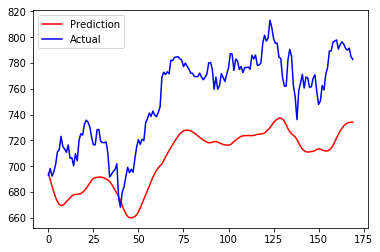

In [48]:
import matplotlib.pyplot as plt2

plt2.plot(newp,color='red', label='Prediction')
plt2.plot(newy_test,color='blue', label='Actual')
plt2.legend(loc='best')
plt2.show()